In [65]:
import pandas as pd
import warnings
import numpy as np
import tensorflow as tf
import os
import sys
child_dir = os.path.abspath('dfl')
sys.path.append(child_dir)
from dfl.whittle import newWhittleIndex
from dfl.trajectory import getSimulatedTrajectories
from dfl.policy import getProbs
from dfl.ope import eval_policy
import matplotlib.pyplot as plt
import datetime
import random
from sklearn.cluster import KMeans

In [66]:
# Helper functions to generate transition dynamics
def get_simpleish_transitions(n_history,n_benefs):
    transitions_full = np.zeros((n, 2 ** n_history, 2, 2 ** n_history))
    transitions = np.zeros((2,2))
    for i in range(n):
        transitions[0, 0] = np.random.uniform(0, 0.5)
        transitions[0, 1] = np.random.uniform(.5, .999)
        transitions[1, 0] = np.random.uniform(0, .7)
        transitions[1, 1] = np.random.uniform(.701, .999)
        for j in range(2 ** history):
            bin_val = bin(j)[2:]
            curr_state = (n_history-len(bin_val))*'0' + bin_val
            next_state_0 = int(curr_state[1:] + '0', 2)
            next_state_1 = int(curr_state[1:] + '1', 2)

            # action = 0
            transitions_full[i, j, 0, next_state_0] = 1 - transitions[int(curr_state[-1]),0]
            transitions_full[i, j, 0, next_state_1] = transitions[int(curr_state[-1]),0]
            # action = 1
            transitions_full[i, j, 1, next_state_0] = 1 - transitions[int(curr_state[-1]),1]
            transitions_full[i, j, 1, next_state_1] = transitions[int(curr_state[-1]),1]
    return transitions_full

In [67]:
# Initialize parameters
L=10
history=1
n_states = 2 ** history
n=500
K=60
gamma=0.99

# We can't release the real world data, but creating synthetic transitions here. Change this as needed.
transition_probabilities = get_simpleish_transitions(history, transition_probabilities)

# generate naive rewards for later
reward_numpy = np.zeros((n, n_states))
for i in range(int(n_states/2)):
    reward_numpy[2*i + 1] = 1
reward_opt = tf.constant(reward_numpy,dtype=tf.float32)

In [68]:
# naive whittle indices for later

w_opt = newWhittleIndex(tf.constant(transition_probabilities, dtype=tf.float32),reward_opt).numpy()
w_opt = np.reshape(w_opt,(n,transition_probabilities.shape[1]))

In [69]:
# We can't release the real world data, but creating synthetic data here. 
# The getSimulatedTrajectories takes in the n: number of beneficiaries, T: length of program, K: resource budget,
# n_trials: number of trajectories to generate, T_data: transitions data, R_data: the rewards with which you want to 
# generate the synthetic trajectories, w: the whittle indices from the rewards and transitions

# You can leave the rest of the parameters as is, or look at the getSimulatedTrajectories code to edit the policy 
# with which you generate policies: 0=random, 1=rount robin, 2=whittle top-k, 3=whittle soft-k

# Lastly, if you want to create a fake trajectory outside of any pre-existing policy, just create a state and action
# trajectory of size (len(policies), n_trials, n_benefs, T) where you set the appropriate state and action values you want to use

# Create the state/action trajectories
_, _, state_traj, action_traj, _ = getSimulatedTrajectories(
                                                                n_benefs=n, T=L+1, K=K, n_trials=1, gamma=gamma,
                                                                T_data=transition_probabilities, R_data=reward_opt.numpy(),
                                                                w=w_opt, replace=False, policies=[3], fast=True
                                                            )

In [70]:
# We can't release the real world data, but creating synthetic feature data here.
def get_risk_score(benef):
    return np.random.randint(0,4)

risk_scores = np.zeros(n,dtype=int)
for i in range(n):
    risk_scores[i] = int(get_risk_score(i))
unique_values, value_counts = np.unique(risk_scores, return_counts=True)
n_risk_groups = len(unique_values)

In [71]:
# Source and target functions for the command "Move Interventions from low risk to high risk groups"

def source_risk(h):
    called_low_risk = set()
    for arm in range(n):
        if edited_action_traj[0,0,h,arm]==1 and risk_scores[arm] in {0,1}:
            called_low_risk.add(arm)
    return called_low_risk

def target_risk(h):
    uncalled_high_risk = set()
    for arm in range(n):
        if edited_action_traj[0,0,h,arm]==0 and risk_scores[arm] in {2,3}:
            uncalled_high_risk.add(arm)
    return uncalled_high_risk

In [72]:
# Applying aggregate command to trajectories

edited_action_traj = np.copy(action_traj)
edited_state_traj = np.copy(state_traj)

def aggregate_command(source, target):
    '''
    state_trajectory - 

    source - function that takes the current timestep and returns a valid list of beneficiaries to remove actions from 

    target - function that takes the current timestep and returns a valid list of beneficiaries to give actions to 
    
    f - feature dataframe

    t - transition matrix
    '''
    
    for h in range(L):
        uncalled_target = target(h)
        called_source = source(h)
        print('source: ' + str(len(called_source)))
        print('target: '+ str(len(uncalled_target)))
        total = len(uncalled_target)
        interventions_available = len(called_source)
        probability_switching = min(float(interventions_available)/total,1)
        num_moved = 0
        arms = np.arange(n)
        np.random.shuffle(arms)
        for arm in arms:
            if edited_action_traj[0,0,h,arm] == 0 and arm in uncalled_target and called_source != set():
                if np.random.uniform()<probability_switching:
                    num_moved+=1
                    edited_action_traj[0,0,h,arm] = 1
                    temp_index = called_source.pop()
                    edited_action_traj[0,0,h,temp_index] = 0

In [84]:
edited_action_traj = np.copy(action_traj)
edited_state_traj = np.copy(state_traj)
aggregate_command(source_risk, target_risk)

source: 27
target: 204
source: 33
target: 210
source: 24
target: 201
source: 35
target: 212
source: 35
target: 212
source: 31
target: 208
source: 26
target: 203
source: 28
target: 205
source: 34
target: 211
source: 33
target: 210


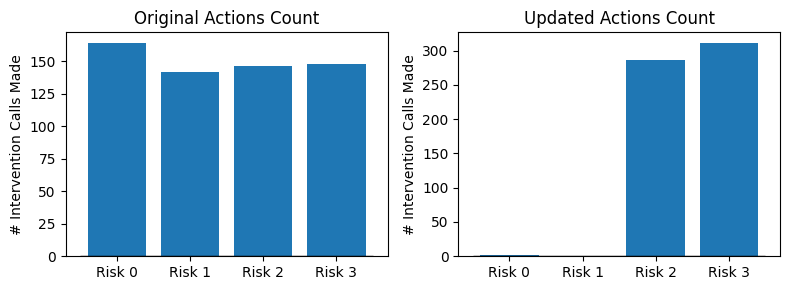

In [85]:
# Visualize how the actions changed after aggregate edits

def get_risk_count(states,actions):
    actions_by_risk = np.zeros(n_risk_groups)
    listening_by_risk = np.zeros(n_risk_groups)
    for i in range(n): # for each beneficary
        for j in range(L): # for each timestep
            actions_by_risk[risk_scores[i]] += actions[0,0,j,i]
            listening_by_risk[risk_scores[i]] += states[0,0,j,i]/float(value_counts[risk_scores[i]])
    return actions_by_risk

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].set_title('Original Actions Count')
axs[0].set_ylabel('# Intervention Calls Made')
axs[0].bar(['Risk 0', 'Risk 1', 'Risk 2','Risk 3'], get_risk_count(state_traj,action_traj))

axs[1].bar(['Risk 0', 'Risk 1', 'Risk 2','Risk 3'], get_risk_count(edited_state_traj,edited_action_traj))
axs[1].set_title('Updated Actions Count')
axs[1].set_ylabel('# Intervention Calls Made')

axs[1].hlines(0, -0.5, 3.5, colors='black', linewidth=1)
axs[0].hlines(0, -0.5, 3.5, colors='black', linewidth=1)

plt.tight_layout()
plt.show()

In [ ]:
# WHIRL - RUN IRL WITH NEW TRAJECTORIES
epochs = 50
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
rewards = np.zeros((n, n_states))
reward_param_edited = tf.Variable(rewards,dtype=float)
for epoch in range(epochs):
    print("epoch: {e}".format(e=epoch))
    with tf.GradientTape() as tape:
        w = newWhittleIndex(tf.constant(transition_probabilities,dtype=tf.float32), reward_param_edited)
        w = tf.reshape(w, (n, n_states))
        print('WHITTLE')
        print(w[0])
        performance, _, _, _,_ = eval_policy(state_record=edited_state_traj, action_record=edited_action_traj, w=w, w_opt=w_opt, H=L, K=K,
                                                  gamma=gamma,
                                                 target_policy_name='soft-whittle', beh_policy_name='soft-whittle',
                                                 transition_probabilities=transition_probabilities, epsilon=0.1, reward_estimate=reward_param_edited, rewards_true=reward_opt)
    grad = tape.gradient(performance, reward_param_edited)
    optimizer.apply_gradients(zip([grad], [reward_param_edited]))
#     print("reward: {r}".format(r = reward_param_edited))
    print("performance: {p}".format(p = performance))
#     print("gradient: {g}".format(g = grad))
    
print("reward: {r}".format(r = reward_param_edited))
df = pd.DataFrame(reward_param_edited.numpy())
# df.to_excel('risk_rewards.xlsx')

epoch: 0
WHITTLE
tf.Tensor([0. 0.], shape=(2,), dtype=float32)
performance: 1651.088623046875
epoch: 1
WHITTLE
tf.Tensor([-0.01853197 -0.01665747], shape=(2,), dtype=float32)
performance: 1532.7476806640625
epoch: 2
WHITTLE
tf.Tensor([-0.04015083 -0.03608949], shape=(2,), dtype=float32)
performance: 1450.6336669921875
epoch: 3
WHITTLE
tf.Tensor([-0.05912617 -0.05314547], shape=(2,), dtype=float32)
performance: 1388.53662109375
epoch: 4
WHITTLE
tf.Tensor([-0.07719138 -0.06938335], shape=(2,), dtype=float32)
performance: 1341.5623779296875
epoch: 5
WHITTLE
tf.Tensor([-0.09424777 -0.08471444], shape=(2,), dtype=float32)
performance: 1308.4129638671875
epoch: 6
WHITTLE
tf.Tensor([-0.11027455 -0.09912011], shape=(2,), dtype=float32)
performance: 1279.2093505859375
epoch: 7
WHITTLE
tf.Tensor([-0.11353049 -0.11260039], shape=(2,), dtype=float32)
performance: 1259.1346435546875
epoch: 8
WHITTLE
tf.Tensor([-0.12628132 -0.11350775], shape=(2,), dtype=float32)
performance: 1242.3416748046875
epoc

In [ ]:
# Get whittle index with new rewards so we can generate hypothetical trajectories for next 10 timesteps

# df = pd.read_excel('risk_rewards.xlsx')
# reward_param_edited = tf.Variable(df.values[:,1:], dtype.float32)

w = newWhittleIndex(tf.constant(transition_probabilities,dtype=tf.float32), reward_param_edited)
w.shape

In [ ]:
# Generate hypothetical trajectories using the IRL rewards
gamma=0.99
num_traj = 60
edited_state_traj_multiple = np.zeros((num_traj,1,L+1,n))
edited_action_traj_multiple = np.zeros((num_traj,1,L+1,n))
w = np.reshape(w,(n,transition_probabilities.shape[1]))
for i in range(num_traj):

    _, _, state_record_edited, action_record_edited, _ = getSimulatedTrajectories(
                                                                    n_benefs=n, T=L+1, K=K, n_trials=1, gamma=gamma,
                                                                    T_data=transition_probabilities, R_data=reward_param_edited.numpy(),
                                                                    w=w, replace=False, policies=[3], fast=True
                                                                    )
    
    edited_state_traj_multiple[i,0,:,:] = state_record_edited
    edited_action_traj_multiple[i,0,:,:] = action_record_edited
    

In [ ]:
# Generate trajectories using the original rewards
reward_numpy = np.zeros((n, n_states))
for i in range(int(n_states/2)):
    reward_numpy[2*i + 1] = 1

reward_opt = tf.constant(reward_numpy,dtype=tf.float32)
w_opt = newWhittleIndex(tf.constant(transition_probabilities, dtype=tf.float32),reward_opt).numpy()
w_opt = np.reshape(w_opt,(n,transition_probabilities.shape[1]))


state_traj_multiple = np.zeros((num_traj,1,L+1,n))
action_traj_multiple = np.zeros((num_traj,1,L+1,n))


for i in range(num_traj):
    _, _, state_record_original, action_record_original, _ = getSimulatedTrajectories(
                                                                    n_benefs=n, T=L+1, K=K, n_trials=1, gamma=gamma,
                                                                    T_data=transition_probabilities, R_data=reward_opt.numpy(),
                                                                    w=w_opt, replace=False, policies=[3], fast=True
                                                                    )
    state_traj_multiple[i,0,:,:] = state_record_original
    action_traj_multiple[i,0,:,:] = action_record_original


In [ ]:
# Generate trajectories using hand crafted "intuitive" rewards
reward_guess = np.zeros((n, n_states))
reward_guess[np.logical_or(risk_scores==0,risk_scores == 1)] = [0.3,0.3]
reward_guess[np.logical_or(risk_scores==2,risk_scores == 3)] = [0,1]

reward_opt_guess = tf.constant(reward_guess,dtype=tf.float32)
w_opt_guess = newWhittleIndex(tf.constant(transition_probabilities, dtype=tf.float32),reward_opt_guess).numpy()
w_opt_guess = np.reshape(w_opt_guess,(n,transition_probabilities.shape[1]))


gamma=0.99
guess_state_traj_multiple = np.zeros((num_traj,1,L+1,n))
guess_action_traj_multiple = np.zeros((num_traj,1,L+1,n))


for i in range(num_traj):
    _, _, state_record_guess, action_record_guess, _ = getSimulatedTrajectories(
                                                                    n_benefs=n, T=L+1, K=K, n_trials=1, gamma=gamma,
                                                                    T_data=transition_probabilities, R_data=reward_opt_guess.numpy(),
                                                                    w=w_opt_guess, replace=False, policies=[2], fast=False
                                                                    )
    guess_state_traj_multiple[i,0,:,:] = state_record_guess
    guess_action_traj_multiple[i,0,:,:] = action_record_guess


In [ ]:
# Count up totals from all 3 hypothetical trajectories above

edited_actions_summary_risk = np.zeros(n_risk_groups)
edited_listening_summary_risk = np.zeros(n_risk_groups)
actions_summary_risk = np.zeros(n_risk_groups)
listening_summary_risk = np.zeros(n_risk_groups)

guess_actions_summary_risk = np.zeros(n_risk_groups)
guess_listening_summary_risk = np.zeros(n_risk_groups)
for traj in range(num_traj):
    for i in range(n): # for each beneficary
        for j in range(10): # for each timestep
            # joint traj is of form (s,a,s',r)
            edited_actions_summary_risk[risk_scores[i]] += edited_action_traj_multiple[traj,0,j,i]
            edited_listening_summary_risk[risk_scores[i]] += edited_state_traj_multiple[traj,0,j,i]
            actions_summary_risk[risk_scores[i]] += action_traj_multiple[traj,0,j,i]
            listening_summary_risk[risk_scores[i]] += state_traj_multiple[traj,0,j,i]
            guess_actions_summary_risk[risk_scores[i]] += guess_action_traj_multiple[traj,0,j,i]
            guess_listening_summary_risk[risk_scores[i]] += guess_state_traj_multiple[traj,0,j,i]
x = np.arange(n_risk_groups)
edited_actions_summary_risk = edited_actions_summary_risk/num_traj
edited_listening_summary_risk = edited_listening_summary_risk/num_traj
actions_summary_risk = actions_summary_risk/num_traj
listening_summary_risk = listening_summary_risk/num_traj

guess_actions_summary_risk = guess_actions_summary_risk/num_traj
guess_listening_summary_risk = guess_listening_summary_risk/num_traj

In [ ]:
# Plot absolute change with naive {0,1} rewards
edited_actions_summary_risk_abs = (edited_actions_summary_risk - actions_summary_risk)
edited_listening_summary_risk_abs = (edited_listening_summary_risk - listening_summary_risk)

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].set_title('Change in intervention calls made after IRL')
axs[0].set_ylabel('Change in Service Calls')
axs[0].bar(['Risk 0', 'Risk 1', 'Risk 2','Risk 3'], edited_actions_summary_risk_abs)
for risk, val in zip(x, edited_actions_summary_risk_abs):
    if val <0:
        va='bottom'
    else:
        va='top'
    axs[0].text(risk, int(val), str(int(val)), ha='center', va=va,color='white')
axs[1].bar(['Risk 0', 'Risk 1', 'Risk 2','Risk 3'], edited_listening_summary_risk_abs)
axs[1].set_title('Change in Listening after IRL')
axs[1].set_ylabel('Change in AVM listened')
for risk, val in zip(x, edited_listening_summary_risk_abs):
    if val <0:
        va='bottom'
    else:
        va='top'
    axs[1].text(risk, int(val), str(int(val)), ha='center', va=va,color='white')
axs[1].hlines(0, -0.5, len(x) - 0.5, colors='black', linewidth=1)
axs[0].hlines(0, -0.5, len(x) - 0.5, colors='black', linewidth=1)

y0_min, y0_max = axs[0].get_ylim()
y1_min, y1_max = axs[1].get_ylim()

plt.tight_layout()
plt.show()

In [ ]:
# Plot uneven action distribution for hand crafted rewards and WHIRL rewards
edited_action_sum = np.sum(edited_action_traj_multiple, axis=(0,1,2))/(num_traj*(L+1))
action_sum = np.sum(action_traj_multiple, axis=(0,1,2))/(num_traj*(L+1))
high_risk_n = len(edited_action_sum[np.logical_or(risk_scores==2,risk_scores == 3)])
fig, axs = plt.subplots(1, 2, figsize=(7, 2))
fig.suptitle("Probability Histogram of High Risk Beneficiaries being Called")
axs[1].hist(np.sort(edited_action_sum[np.logical_or(risk_scores==2,risk_scores == 3)]),color="#ffa600",label="WHIRL Rewards",bins=100)
axs[0].hist(np.sort(action_sum[np.logical_or(risk_scores==2,risk_scores == 3)]),color="#bc5090",label="Hand Crafted Rewards",bins=100)
axs[0].legend()
axs[1].legend()
axs[0].set_ylabel("# Beneficiaries")
axs[1].set_ylabel("# Beneficiaries")
axs[0].set_xlabel("Probability of being Called")
axs[1].set_xlabel("Probability of being Called")


In [ ]:
# Plot WHIRL rewards clustered
filtered_df_low = df[np.logical_or(risk_scores==0,risk_scores == 1)]
filtered_df_high = df[np.logical_or(risk_scores==2,risk_scores == 3)]
num_clusters = 3 # Number of clusters
points = filtered_df_high[[0,1]]
print(len(points))
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(points)
cluster_labels = kmeans.labels_

fig, axs = plt.subplots(1, 2, figsize=(11, 4))
cluster_colors =  ['#03045e', '#0077b6',  '#00b4d8', '#90e0ef','#caf0f8']
axs[0].set_title('Learned Rewards for all Beneficiaries')
axs[0].set_ylabel('Reward at State 1')
axs[0].set_xlabel('Reward at State 0')
axs[1].set_xlabel('Reward at State 0')
axs[0].scatter((filtered_df_high[0]), (filtered_df_high[1]),label="high risk",s=10)
axs[0].scatter((filtered_df_low[0]), (filtered_df_low[1]),label="low risk",s=10)

i=0
for cluster_label in range(num_clusters):
    cluster_points = points[cluster_labels == cluster_label]
    axs[1].scatter(cluster_points[0], cluster_points[1], label=f'Cluster {cluster_label}')
    i+=1
axs[1].set_title('Learned Rewards for High Risk Beneficiaries')
axs[1].set_ylabel('Reward at State 1')

axs[1].legend()
axs[0].legend()
plt.tight_layout()
plt.show()